In [1]:
# %init
import glob, sys, os, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from yahist import Hist1D, Hist2D
import glob
np.set_printoptions(linewidth=150)
import json

from myhelpers.dataframes import fix_types
from myhelpers.personal import sqlite_magic

In [7]:
if not os.path.exists("data.parquet"):
    fnames = glob.glob("data/*json")
    data = []
    for fname in fnames:
        with open(fname) as fh:
            try:
                js = json.load(fh)
            except:
                pass
            data.append(dict(
                total_without_power = js["summaryFileData"]["totals"][0]["total_cust_a"]["val"],
                total = js["summaryFileData"]["totals"][0]["total_cust_s"],
                total_outages = js["summaryFileData"]["totals"][0]["total_outages"],
                generated_ts = js["summaryFileData"]["date_generated"],
            ))
    dfc = pd.DataFrame(data)
    dfc["generated_ts"] = pd.to_datetime(dfc["generated_ts"], format="mixed").apply(lambda x: x.replace(tzinfo=None)) - pd.Timedelta("6 hours")

    # from https://www.reddit.com/r/Austin/comments/10qpco1/power_outage_status_thread/
    df = pd.DataFrame([
        {"generated_ts":"2023-02-01 03:36", "total_without_power": 13000, "total":543107, "total_outages": 26},
        {"generated_ts":"2023-02-01 03:42", "total_without_power": 16742, "total":543107, "total_outages": None},
        {"generated_ts":"2023-02-01 03:52", "total_without_power": 21981, "total":543107, "total_outages": None},
        {"generated_ts":"2023-02-01 04:02", "total_without_power": 25864, "total":543107, "total_outages": None},
        {"generated_ts":"2023-02-01 04:22", "total_without_power": 31285, "total":543107, "total_outages": None},
        {"generated_ts":"2023-02-01 04:42", "total_without_power": 43043, "total":543107, "total_outages": 163},
        {"generated_ts":"2023-02-01 05:00", "total_without_power": 50700, "total":543107, "total_outages": 149},
        {"generated_ts":"2023-02-01 05:12", "total_without_power": 51908, "total":543107, "total_outages": 157},

        {"generated_ts":"2023-02-01 05:42", "total_without_power": 61176, "total":543107, "total_outages": 196},
        {"generated_ts":"2023-02-01 05:52", "total_without_power": 66759, "total":543107, "total_outages": 204},
        {"generated_ts":"2023-02-01 06:13", "total_without_power": 73084, "total":543107, "total_outages": 256},
        {"generated_ts":"2023-02-01 06:23", "total_without_power": 81894, "total":543107, "total_outages": 290},
        {"generated_ts":"2023-02-01 07:13", "total_without_power": 100462, "total":543107, "total_outages": 316},
        {"generated_ts":"2023-02-01 08:38", "total_without_power": 125197, "total":543107, "total_outages": 435},
        {"generated_ts":"2023-02-01 15:32", "total_without_power": 171268, "total":543107, "total_outages": 803},
        {"generated_ts":"2023-02-01 21:10", "total_without_power": 159519, "total":543107, "total_outages": 1031},
    ]).ffill()
    df["generated_ts"] = pd.to_datetime(df["generated_ts"])

    dfc = pd.concat([dfc,df],axis=0)

    dfc = dfc.drop_duplicates("generated_ts")
    dfc = dfc.set_index("generated_ts").sort_index()
    dfc.to_parquet("data.parquet")
    dfc.head()
else:
    dfc = pd.read_parquet("data.parquet")

parameter,value
a,7.501e+08 ± 4.773e+06
b,-3.868e+04 ± 246.1


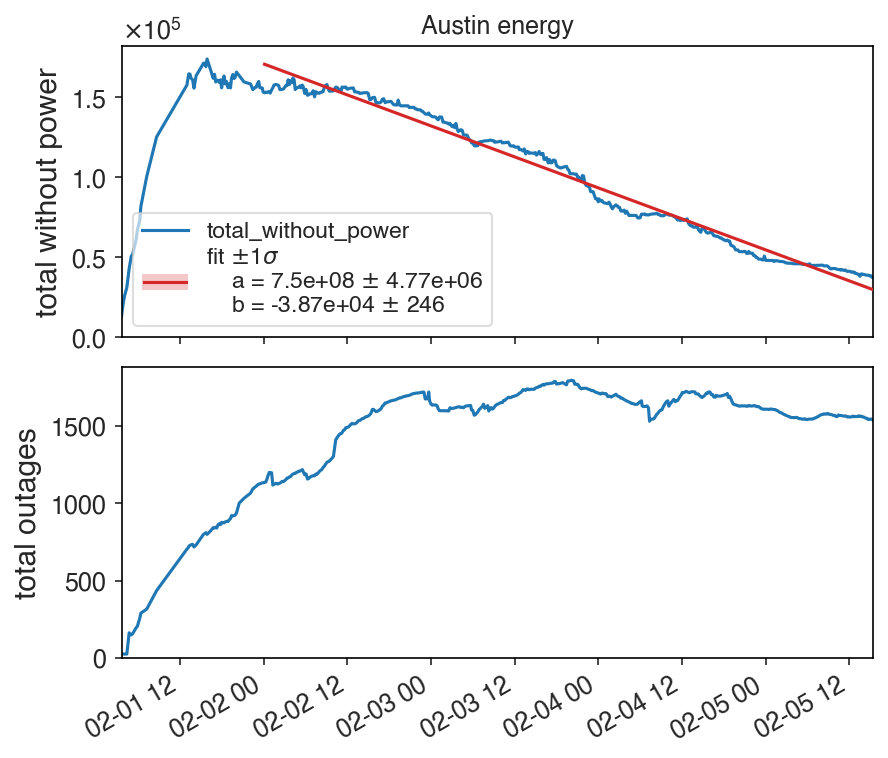

In [8]:
fig, (ax1,ax2) = plt.subplots(2,1, sharex=True, figsize=(6,6))
dfc["total_without_power"].plot(ylim=(0,None), ax=ax1, ylabel="total without power", xlabel="")
dfc["total_outages"].plot(ylim=(0,None), ax=ax2, ylabel="total outages", xlabel="")
ax1.set_title("Austin energy")

from tidfit import fit
sel = dfc.index > "2023-02-02 12am"
fit("a+b*x", dfc[sel].index, dfc[sel]["total_without_power"], ax=ax1)